In [1]:
import xgboost as xgb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.model_selection import train_test_split
import contextily as cx

In [2]:
data = pd.read_csv('../dataset/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data['lat'] = data['geometry'].get_coordinates()['x']
data['lon'] = data['geometry'].get_coordinates()['y']

In [6]:
data['price'] = np.power(10, data['log_price']) / 10000

In [7]:
data

,Unnamed: 0,bathrooms,sqft_living,sqft_lot,grade,condition,waterfront,view,age,UTM_X,UTM_Y,log_price,geometry,lat,lon,price
0,0,3.00,2660,4600,8,3,0,0,109,552217.557035,5.274945e+06,6.091315,POINT (-122.30500 47.62580),-122.305,47.6258,123.4000
1,1,2.25,2530,8736,7,4,0,0,57,565692.484331,5.272758e+06,5.790988,POINT (-122.12600 47.60490),-122.126,47.6049,61.8000
2,2,2.00,1390,13464,7,4,0,0,28,562451.661509,5.245291e+06,5.315130,POINT (-122.17300 47.35810),-122.173,47.3581,20.6600
3,3,1.00,940,4264,7,5,0,0,66,546816.935618,5.264407e+06,5.619093,POINT (-122.37800 47.53140),-122.378,47.5314,41.6000
4,4,2.25,2070,7225,8,3,0,0,36,564343.195352,5.244978e+06,5.477121,POINT (-122.14800 47.35510),-122.148,47.3551,30.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,1.50,1290,8366,7,3,0,0,58,551377.991268,5.259321e+06,5.380211,POINT (-122.31800 47.48530),-122.318,47.4853,24.0000
2996,2996,1.50,1490,12186,7,4,0,0,65,550796.231636,5.291393e+06,5.566895,POINT (-122.32200 47.77390),-122.322,47.7739,36.8888
2997,2997,1.50,1510,16800,8,5,0,0,59,549619.278143,5.288838e+06,5.618048,POINT (-122.33800 47.75100),-122.338,47.7510,41.5000
2998,2998,2.00,1640,3021,7,3,0,2,56,548198.517745,5.279378e+06,5.732394,POINT (-122.35800 47.66600),-122.358,47.6660,54.0000


In [8]:
y = data.price
X = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
loc = data[['lat','lon']]

In [9]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X, y, loc, train_size=0.8, random_state=42)

In [10]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [11]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0).fit(X_train.values, y_train.values)

In [12]:
model.score(X_test, y_test)

0.8705986887146308

In [13]:
from GeoConformalPrediction import GeoConformalRegressor

In [14]:
geocp_regressoer = GeoConformalRegressor(predict_f=model.predict, x_calib=X_calib.values, y_calib=y_calib.values, coord_calib=loc_calib.values, bandwidth=0.15, miscoverage_level=0.1)

In [15]:
y_test.values

array([ 87.995 ,  33.3   ,  33.6   ,  42.    ,  31.5   ,  78.5   ,
        23.    ,  38.    ,  48.99  ,  49.9   , 205.    ,  40.5   ,
        15.16  ,  23.995 ,  40.    ,  12.5   ,  41.1715,  16.    ,
        23.    ,  55.5   ,  41.49  ,  76.5   ,  55.    ,  27.    ,
        61.25  ,  40.6   ,  51.5   ,  30.89  ,  42.5   ,  39.75  ,
        47.    ,  21.    ,  77.1   ,  43.75  ,  25.    ,  28.03  ,
        34.99  ,  25.08  ,  52.5   ,  45.7   ,  77.5   ,  47.7   ,
        31.2   ,  54.    ,  42.    ,  43.5   ,  53.    ,  32.    ,
        29.    ,  71.9   ,  21.5   ,  30.5   ,  99.2   ,  27.    ,
        44.95  ,  27.5   ,  89.8   ,  41.85  ,  42.5   ,  50.    ,
       116.5   ,  26.5   ,  25.3   ,  26.    ,  70.6   ,  35.8   ,
        47.48  ,  33.    , 227.115 ,  47.5   ,  24.5   ,  65.8   ,
       100.    ,  29.6   ,  85.    ,  76.5   ,  49.    ,  47.8   ,
        57.5   ,  67.25  ,  34.    ,  33.9   ,  51.6   ,  84.    ,
        30.    ,  76.8   ,  46.    ,  49.5   ,  22.795 ,  69.9

In [16]:
results = geocp_regressoer.geo_conformalize(X_test.values, y_test.values, loc_test.values)

In [17]:
results.coverage

0.94

In [18]:
results_geo = results.to_gpd()

<GeoAxes: >

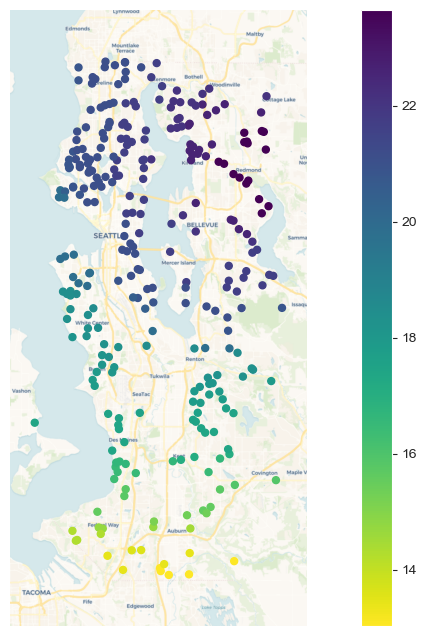

In [19]:
utm = gcrs.WebMercator()

ax = gplt.webmap(results_geo, projection=utm, figsize=(14, 8), provider=cx.providers.CartoDB.Voyager)

gplt.pointplot(results_geo, hue='geo_uncertainty', cmap='viridis_r', legend=True, ax=ax)